# MLFlow Workshop - Sequence 2 - Projects API

## Install dependencies

In [1]:
!pip -q install mlflow

     |████████████████████████████████| 17.8 MB 293 kB/s 
     |████████████████████████████████| 79 kB 2.6 MB/s 
     |████████████████████████████████| 181 kB 33.2 MB/s 
     |████████████████████████████████| 146 kB 8.9 MB/s 
     |████████████████████████████████| 67 kB 1.6 MB/s 
     |████████████████████████████████| 209 kB 39.9 MB/s 
     |████████████████████████████████| 596 kB 38.4 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 78 kB 5.0 MB/s 


In [ ]:
#!git clone https://github.com/mlflow/mlflow-example.git

In [ ]:
!mlflow run --env-manager=local https://github.com/mlflow/mlflow-example.git -P alpha=0.5

2022/06/10 14:42:58 INFO mlflow.projects.utils: === Fetching project from https://github.com/mlflow/mlflow-example.git into /tmp/tmp7ezkevv4 ===
2022/06/10 14:42:58 INFO mlflow.projects.utils: === Created directory /tmp/tmpkpvxdy68 for downloading remote URIs passed to arguments of type 'path' ===
2022/06/10 14:42:58 INFO mlflow.projects.backend.local: === Running command 'python train.py 0.5 0.1' in run with ID '0ea8c3faaf784e1d8d87b840d34d56c6' === 
Elasticnet model (alpha=0.500000, l1_ratio=0.100000):
  RMSE: 0.7947931019036528
  MAE: 0.6189130834228137
  R2: 0.1841166871822183
2022/06/10 14:43:03 INFO mlflow.projects: === Run (ID '0ea8c3faaf784e1d8d87b840d34d56c6') succeeded ===


There is a helper package that makes installing Conda on Google Colab a breeze:

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda --version

In [ ]:
# !pip --quiet install gdown
# import gdown
# gdown.download_folder("https://drive.google.com/drive/folders/1Cs4HJAhy6XTtUjg0XyfyFeolLFf1jz3C?usp=sharing", quiet=True)

## Setting up our script for the command line

First, we need to add a way for MLFlow to be able to pass arguments to our script(s).

If you aren't comfortable with a Python IDE or want to stay within Colab, you can first download your Colab notebook as a Python (.py) script.

Click on File and navigate to the bottom of the selections:
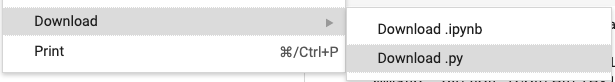

Now, let's clean up the script and add a few lines of code that will allow us to avoid hard-coded arguments.

In [7]:
%%writefile mlflow_regression_housing.py

# -*- coding: utf-8 -*-
#EX1_MLFlow_Tracking_Regression_Homegate.ipynb
#Automatically generated by Colaboratory.

#Original file is located at
#    https://colab.research.google.com/drive/1Rl3N-X41fKfyZ-c-hQ9qPK48B5O1wQ-H

# Load Dependencies

import os
import warnings
import sys

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import mlflow
import mlflow.sklearn

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

"""# Utilities for Data and Metrics"""

def prepare_data():
    #id = 1eNTyJc4jXJMkLPXW0eY6LL7_P9YN1GWO
    warnings.filterwarnings("ignore")
    np.random.seed(42)

    # Read the home price csv file from the URL
    orig_url = "https://drive.google.com/file/d/1eNTyJc4jXJMkLPXW0eY6LL7_P9YN1GWO/view"
    file_id = orig_url.split('/')[-2]
    data_path='https://drive.google.com/uc?export=download&id=' + file_id
    
    try:
        data = pd.read_csv(data_path)
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e)
    
    #numbers are written in this format "1,235,00" converting them to integers
    data["price"] = data["price"].str.replace(',', '')
    data["price"] = pd.to_numeric(data["price"])
    data = data.drop(["Unnamed: 0", 'zip'], 1)
    data = data.dropna()

    y = data["price"]
    X = data.drop("price", 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

"""# Load Dataset"""

X_train, X_test, y_train, y_test = prepare_data()

data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

data['X_train'].head()

data['y_train'].head()

"""# Utilities for Modeling and Tracking Experiments"""

def train_elasticnet(data, alpha=0.5, l1_ratio=0.5):

    # Train and track experiment
    with mlflow.start_run():

        categorical_features = ['type', 'floor', 'city', 'canton']
        continious_features = ['room_num', 'area_m2', 'floors_num', 'year_built', 'last_refurbishment', 'lat', 'lon']

        numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

        categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

        preprocessor = ColumnTransformer( transformers = [("num", numeric_transformer, continious_features),
                    ("cat", categorical_transformer, categorical_features)])

        # Execute ElasticNet
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        pipeline_lr = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", lr)])
        pipeline_lr.fit(data['X_train'], data['y_train'])

        # Evaluate Metrics
        predicted_qualities = pipeline_lr.predict(data['X_test'])
        (rmse, mae, r2) = eval_metrics(data['y_test'], predicted_qualities)

        # Print out metrics
        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('Model', 'ElasticNet')  
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(pipeline_lr, "model")

def train_random_forest(data, n_trees=100, max_depth=None):

    # Train and track experiment   
    with mlflow.start_run():

        categorical_features = ['type', 'floor', 'city', 'canton']
        continious_features = ['room_num', 'area_m2', 'floors_num', 'year_built', 'last_refurbishment', 'lat', 'lon']

        numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

        categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

        preprocessor = ColumnTransformer( transformers = [("num", numeric_transformer, continious_features),
                    ("cat", categorical_transformer, categorical_features)])
        
        # Execute RF
        rf = RandomForestRegressor(n_estimators=n_trees, max_depth=max_depth, random_state=42)
        pipeline_rf = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", rf)])
        pipeline_rf.fit(data['X_train'], data['y_train'])

        # Evaluate Metrics
        predicted_qualities = pipeline_rf.predict(data['X_test'])
        (rmse, mae, r2) = eval_metrics(data['y_test'], predicted_qualities)

        # Print out metrics
        print("Random Forest model (n_estimators={}, max_depth={}):".format(n_trees, max_depth))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('Model', 'Random Forest')  
        mlflow.log_param("n_estimators", n_trees)
        mlflow.log_param("max_depth", max_depth)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(pipeline_rf, "model")

Writing mlflow_regression_housing.py


**Positional (simple):**

In [ ]:
import sys

alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5

**Keyword & positional (recommended):**

In [ ]:
import argparse

## MLFlow Projects

Let's go back to our regression model run example. Imagine that we were happy with our model and wanted to share it with colleagues/others, including those with less technical backgrounds.

Let's try packaging what we did with a the `MLFlow Projects API`, and encoding what we did in a `MLProject` *yaml* file.

### `MLProject` *YAML* file

First, let's look at the anatomy of an `MLProject` file.



*   *MLProject* yaml file
  - parameters
  - entrypoints


```yaml
name: My Project

conda_env: my_env.yaml
# Can have a docker_env instead of a conda_env, e.g.
# docker_env:
#    image:  mlflow-docker-example

entry_points:
  main:
    parameters:
      data_file: path
      regularization: {type: float, default: 0.1}
    command: "python train.py -r {regularization} {data_file}"
  validate:
    parameters:
      data_file: path
    command: "python validate.py {data_file}"
```

[CLI](https://mlflow.org/docs/latest/cli.html#cli):

In [ ]:
# command-line
!mlflow run git@github.com:mlflow/mlflow-example.git -P alpha=0.5

Now let's try adapting it to our regression example!

## Regression example - MLProject YAML file

```yaml
name: housing_regression

conda_env: regression_env.yaml

entry_points:
  main:
    parameters:
      data_file: path
      model_type: {type: str, default: 'all'}
      metrics: {type: str, default: 'all'}
      regularization: {type: float, default: 0.1}
      alpha: {type: float, default: 0.5}
      l1_ratio: {type: float, default: 0.5}
    command: "python train.py -r {data_file} {model_type} {metrics} {regularization} {alpha} {l1_ratio}"
```

## Running MLFlow from our *MLProject* file

```yaml
 name: housing_regression

entry_points:
  main:
    parameters:
      alpha: {type: float, default: 0.5}
      l1_ratio: {type: float, default: 0.5}
    command: "python /content/ex1_mlflow_tracking_regression_homegate.py {alpha} {l1_ratio}"
```

Now let's try runs where we change one parameter between runs.

In [ ]:
!mlflow run . --env-manager=local -P alpha=0.1

/usr/local/lib/python3.7/dist-packages/click/core.py:123: FutureWarning: `--no-conda` is deprecated and will be removed in a future MLflow release. Use `--env-manager=local` instead.
  return callback(ctx, param, value)
2022/06/10 12:57:45 INFO mlflow.projects.utils: === Created directory /tmp/tmpyhfwfg47 for downloading remote URIs passed to arguments of type 'path' ===
2022/06/10 12:57:45 INFO mlflow.projects.backend.local: === Running command 'python /content/ex1_mlflow_tracking_regression_homegate.py 0.1 0.5' in run with ID '75e0e279e940462a9f4fa6674d130d88' === 
2022/06/10 12:57:48 INFO mlflow.projects: === Run (ID '75e0e279e940462a9f4fa6674d130d88') succeeded ===


In [ ]:
!mlflow run . --env-manager=local -P alpha=0.4

/usr/local/lib/python3.7/dist-packages/click/core.py:123: FutureWarning: `--no-conda` is deprecated and will be removed in a future MLflow release. Use `--env-manager=local` instead.
  return callback(ctx, param, value)
2022/06/10 13:27:34 INFO mlflow.projects.utils: === Created directory /tmp/tmp3vvfdkuc for downloading remote URIs passed to arguments of type 'path' ===
2022/06/10 13:27:34 INFO mlflow.projects.backend.local: === Running command 'python /content/ex1_mlflow_tracking_regression_homegate.py 0.4 0.5' in run with ID '2098d515ec3f4ae383bcb4a320e58269' === 
2022/06/10 13:27:37 INFO mlflow.projects: === Run (ID '2098d515ec3f4ae383bcb4a320e58269') succeeded ===


## Checking the results with `mlflow ui`

In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [ ]:
!mlflow ui --port 5000

## Running MLFlow Projects without the command line

Via Python:

In [ ]:
#mlflow.projects.run(
mlflow.run(
    uri,
    entry_point='main',
    version=None,
    parameters=None, #dict of params, e.g. {"alpha": 0.5, "l1_ratio": 0.01}
    docker_args=None,
    experiment_name=None,
    experiment_id=None,
    backend='local',
    backend_config=None,
    #storage_dir=None,
    synchronous=True,
    run_id=None,
    run_name=None,
    env_manager=None #conda is default
    )

# returns mlflow.projects.SubmittedRun object

## [END - SCRATCH BELOW THIS POINT]

### Additional MLFlow examples

Have example w/ working conda env ([Docker examples?](https://mlflow.org/docs/latest/projects.html#mlproject-specify-environment))

In [ ]:
!git clone https://github.com/mlflow/mlflow

Cloning into 'mlflow'...
remote: Enumerating objects: 52054, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 52054 (delta 174), reused 287 (delta 148), pack-reused 51696
Receiving objects: 100% (52054/52054), 77.36 MiB | 27.03 MiB/s, done.
Resolving deltas: 100% (39791/39791), done.


In [ ]:
%cd mlflow/examples

catboost	    paddle			shap
databricks	    pip_requirements		sklearn_autolog
diviner		    pmdarima			sklearn_elasticnet_diabetes
docker		    prophet			sklearn_elasticnet_wine
evaluation	    pyspark_ml_autologging	sklearn_logistic_regression
fastai		    pytorch			spacy
flower_classifier   quickstart			spark_udf
gluon		    rapids			statsmodels
h2o		    ray_serve			supply_chain_security
hyperparam	    README.md			tensorflow
keras		    remote_store		virtualenv
lightgbm	    rest_api			xgboost
mlflow_artifacts    restore_model_dependencies
multistep_workflow  r_wine
/content/mlflow/examples


**Iteration**

Show examples for multi-step project execution, e.g.:

*   Cross-validation
*   Hyperparam tuning

https://github.com/mlflow/mlflow/tree/master/examples/multistep_workflow

In [ ]:
!ls multistep_workflow

als.py	    etl_data.py       main.py	 README.rst	      train_keras.py
conda.yaml  load_raw_data.py  MLproject  spark-defaults.conf


In [ ]:
from mlflow.utils import mlflow_tags
from mlflow.entities import RunStatus
from mlflow.utils.logging_utils import eprint
from mlflow.tracking.fluent import _get_experiment_id

client = mlflow.tracking.MlflowClient()
experiment_id = ""

all_runs = client.list_run_infos(experiment_id)

#mlflow_tags.MLFLOW_GIT_COMMIT

#client.get_run(run_info.run_id)
#run_info.to_proto().status

#run.data.tags.get(mlflow_tags.MLFLOW_GIT_COMMIT)